In [26]:
import pandas as pd
import urllib.parse
import networkx as nx
import matplotlib.pyplot as plt


# URLデコードとHTTPバージョンの削除を行う関数
def decode_url_and_remove_HTTPversion(encoded_url: str) -> str:
    return urllib.parse.unquote(encoded_url).replace(" HTTP/1.1", "").replace("GET /", "/")

# データフレームのフィルタリングを行う関数
def filter_dataframe(df: pd.DataFrame, ip: str) -> pd.DataFrame:
    df = df[df['IP'] == ip]
    df = df[df['Referer'] != '-']
    df['Request'] = df['Request'].apply(decode_url_and_remove_HTTPversion)
    df = df[df['Request'].str.contains('/browse/|/product/')]
    df = df[~df['Request'].str.match(r'^(/image|/product/image)')]
    df['Request'] = df['Request'].apply(lambda url: url.split('/')[-1])
    df = df[df['Request'] != '']
    df['next_request'] = df.groupby('IP')['Request'].shift(-1)
    df = df.dropna(subset=['next_request'])
    df.sort_values(by='DateTime', inplace=True)
    return df

# メインの処理
dataFrame:pd.DataFrame = pd.read_csv('./data/access.csv')
'''
--------top-------
66.249.66.194  : Google crawler
66.249.66.91   : Google crawler but there is no access url under /browse or /product
151.239.241.163: May be employee(there is many request to upload image endpoint)
66.249.66.92   : Google crawler but there is no access url under /browse or /product
91.99.30.32    : may be employee
104.222.32.91  : Scanning? This ip hosts Cloud and domain system website.
91.99.72.15    : referer is deleted,Scanning? internet service provider
91.99.47.57    :employee
--------random------
178.253.33.51  :referer is deleted
89.199.193.251 :referer is deleted
78.38.46.48    :user
91.99.72.15    :referer is deleted?
5.113.217.22   :user
204.18.53.39   :user
83.121.20.38   :referrer i deleted?
31.56.217.232  :referer is deleted?
217.146.220.33 :light user
104.222.32.94  :light user
'''
filtered_df = filter_dataframe(dataFrame, '204.18.53.39')


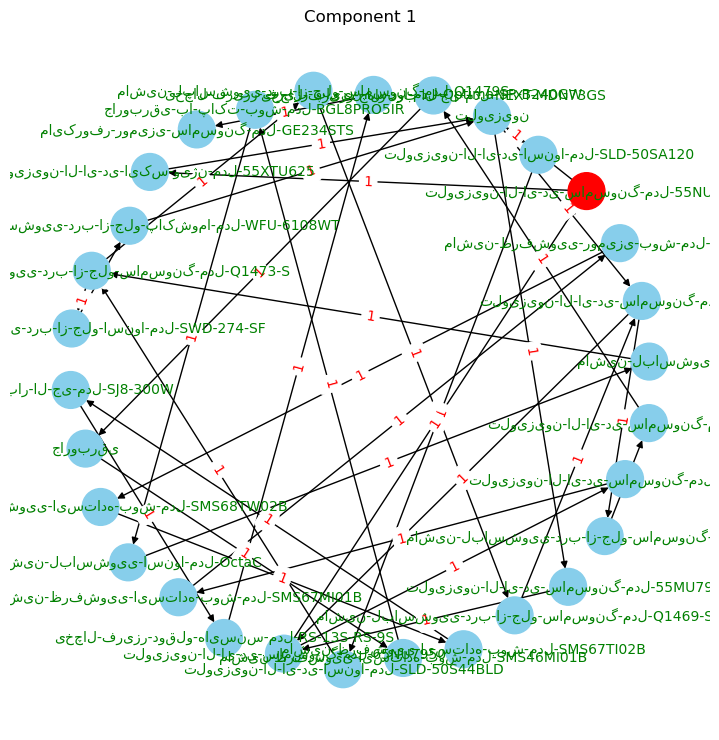

('تلویزیون', 'تلویزیون-ال-ای-دی-اسنوا-مدل-SLD-50SA120'): 1
('تلویزیون', 'تلویزیون-ال-ای-دی-سامسونگ-مدل-55MU7995'): 1
('تلویزیون', 'تلویزیون-ال-ای-دی-سامسونگ-مدل-55MU8990'): 1
('تلویزیون-ال-ای-دی-اسنوا-مدل-SLD-50SA120', 'تلویزیون-ال-ای-دی-اسنوا-مدل-SLD-50S44BLD'): 1
('تلویزیون-ال-ای-دی-سامسونگ-مدل-55MU7995', 'تلویزیون-ال-ای-دی-سامسونگ-مدل-65NU7950'): 1
('تلویزیون-ال-ای-دی-سامسونگ-مدل-55MU8990', 'تلویزیون-ال-ای-دی-سامسونگ-مدل-65NU7950'): 1
('تلویزیون-ال-ای-دی-سامسونگ-مدل-55MU8990', 'ماشین-لباسشویی-درب-از-جلو-سامسونگ-مدل-Q1468-S'): 1
('تلویزیون-ال-ای-دی-اسنوا-مدل-SLD-50S44BLD', 'ماشین-لباسشویی-درب-از-جلو-سامسونگ-مدل-Q1473-S'): 1
('ماشین-لباسشویی-درب-از-جلو-سامسونگ-مدل-Q1473-S', 'ماشین-لباسشویی-درب-از-جلو-اسنوا-مدل-SWD-274-SF'): 1
('ماشین-لباسشویی-درب-از-جلو-سامسونگ-مدل-Q1473-S', 'ماشین-لباسشویی-درب-از-جلو-سامسونگ-مدل-Q1479S'): 1
('تلویزیون-ال-ای-دی-ایکس-ویژن-مدل-55XTU625', 'تلویزیون'): 1
('تلویزیون-ال-ای-دی-سامسونگ-مدل-49N6950', 'ماشین-ظرفشویی-ایستاده-بوش-مدل-SMS67MI01B'): 1
('ماشین-ظرفشو

In [27]:

# グラフの描画とエッジの重みの表示を行う関数
def draw_graph_and_display_weights(df: pd.DataFrame):
    transition_counts = df.groupby(['Request', 'next_request']).size().reset_index(name='count')
    G = nx.DiGraph()
    G.add_weighted_edges_from((row['Request'], row['next_request'], row['count']) for _, row in transition_counts.iterrows() if row['Request'] != row['next_request'])
    components = list(nx.weakly_connected_components(G))
    for i, nodes in enumerate(components):
        H = G.subgraph(nodes)
        plt.figure(figsize=(7, 7))
        pos = nx.spring_layout(H, k=30, iterations=200)
        edge_weights = nx.get_edge_attributes(H, 'weight')
        initial_request =filtered_df.iloc[0]['Request']
        node_colors = ['red' if node == initial_request else 'skyblue' for node in H]
        nx.draw(H, pos, with_labels=True, node_size=700, node_color=node_colors, font_size=10, width=list(edge_weights.values()), font_color='green')
        nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_weights, font_color='red')
        plt.title(f'Component {i+1}')
        plt.show()
        edge_weights = nx.get_edge_attributes(H, 'weight')
        sorted_edges = sorted(edge_weights.items(), key=lambda item: item[1], reverse=True)
        for edge, weight in sorted_edges:
            print(f"{edge}: {weight}")

draw_graph_and_display_weights(filtered_df)